
Training models for RELIANCE

Loaded price from data/reliance/price_data_reliance.csv
Data shape after cleaning: (2929, 5)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
NaN check: 0 NaN values

Data prepared:
  Total samples: 2909
  Window size: 20
  Features: 5

Data split:
  Train: 2036 samples
  Val: 436 samples
  Test: 437 samples

------------------------------------------------------------
Training BiLSTM model...
------------------------------------------------------------
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - calc_r2_score: -0.0038 - loss: 0.0031 - mae: 0.0428 - mse: 0.0031 - rmse: 0.0531 - val_calc_r2_score: -11.6777 - val_loss: 0.0051 - val_mae: 0.0639 - val_mse: 0.0051 - val_rmse: 0.0697 - learning_rate: 0.0010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - calc_r2_score: 0.9312 - loss: 8.0623e-04 - mae: 0.0197 - mse: 8.0623e-04 - rmse: 0.0267 - val_calc_r2_score: -2.9050 - val_loss: 0.0017 - val_mae: 0.0337 - val_mse: 0.0017 - val_rmse: 0.0390 

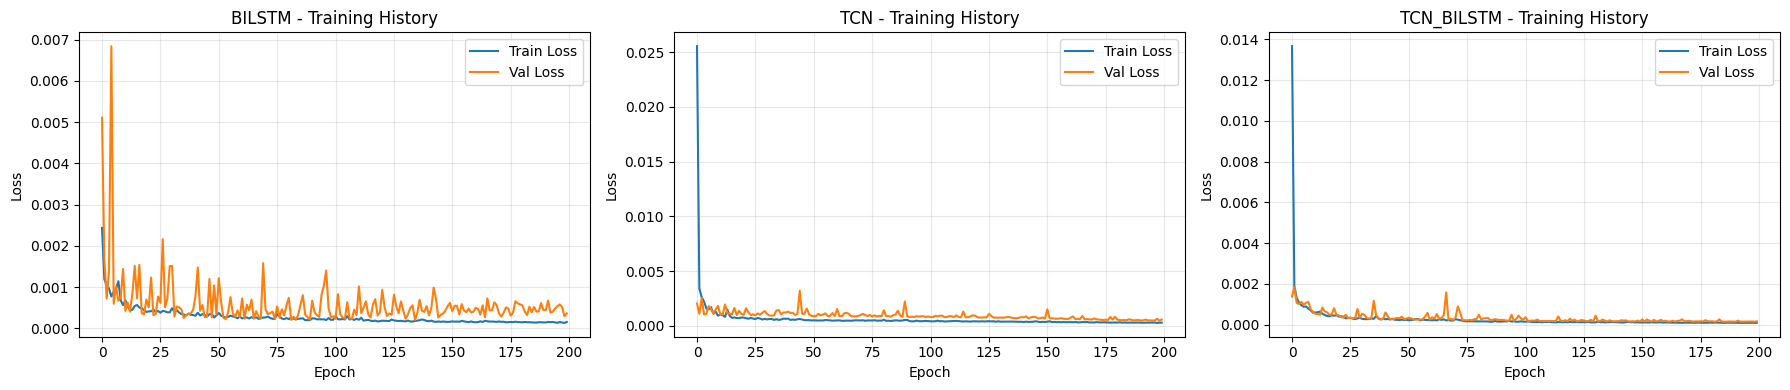

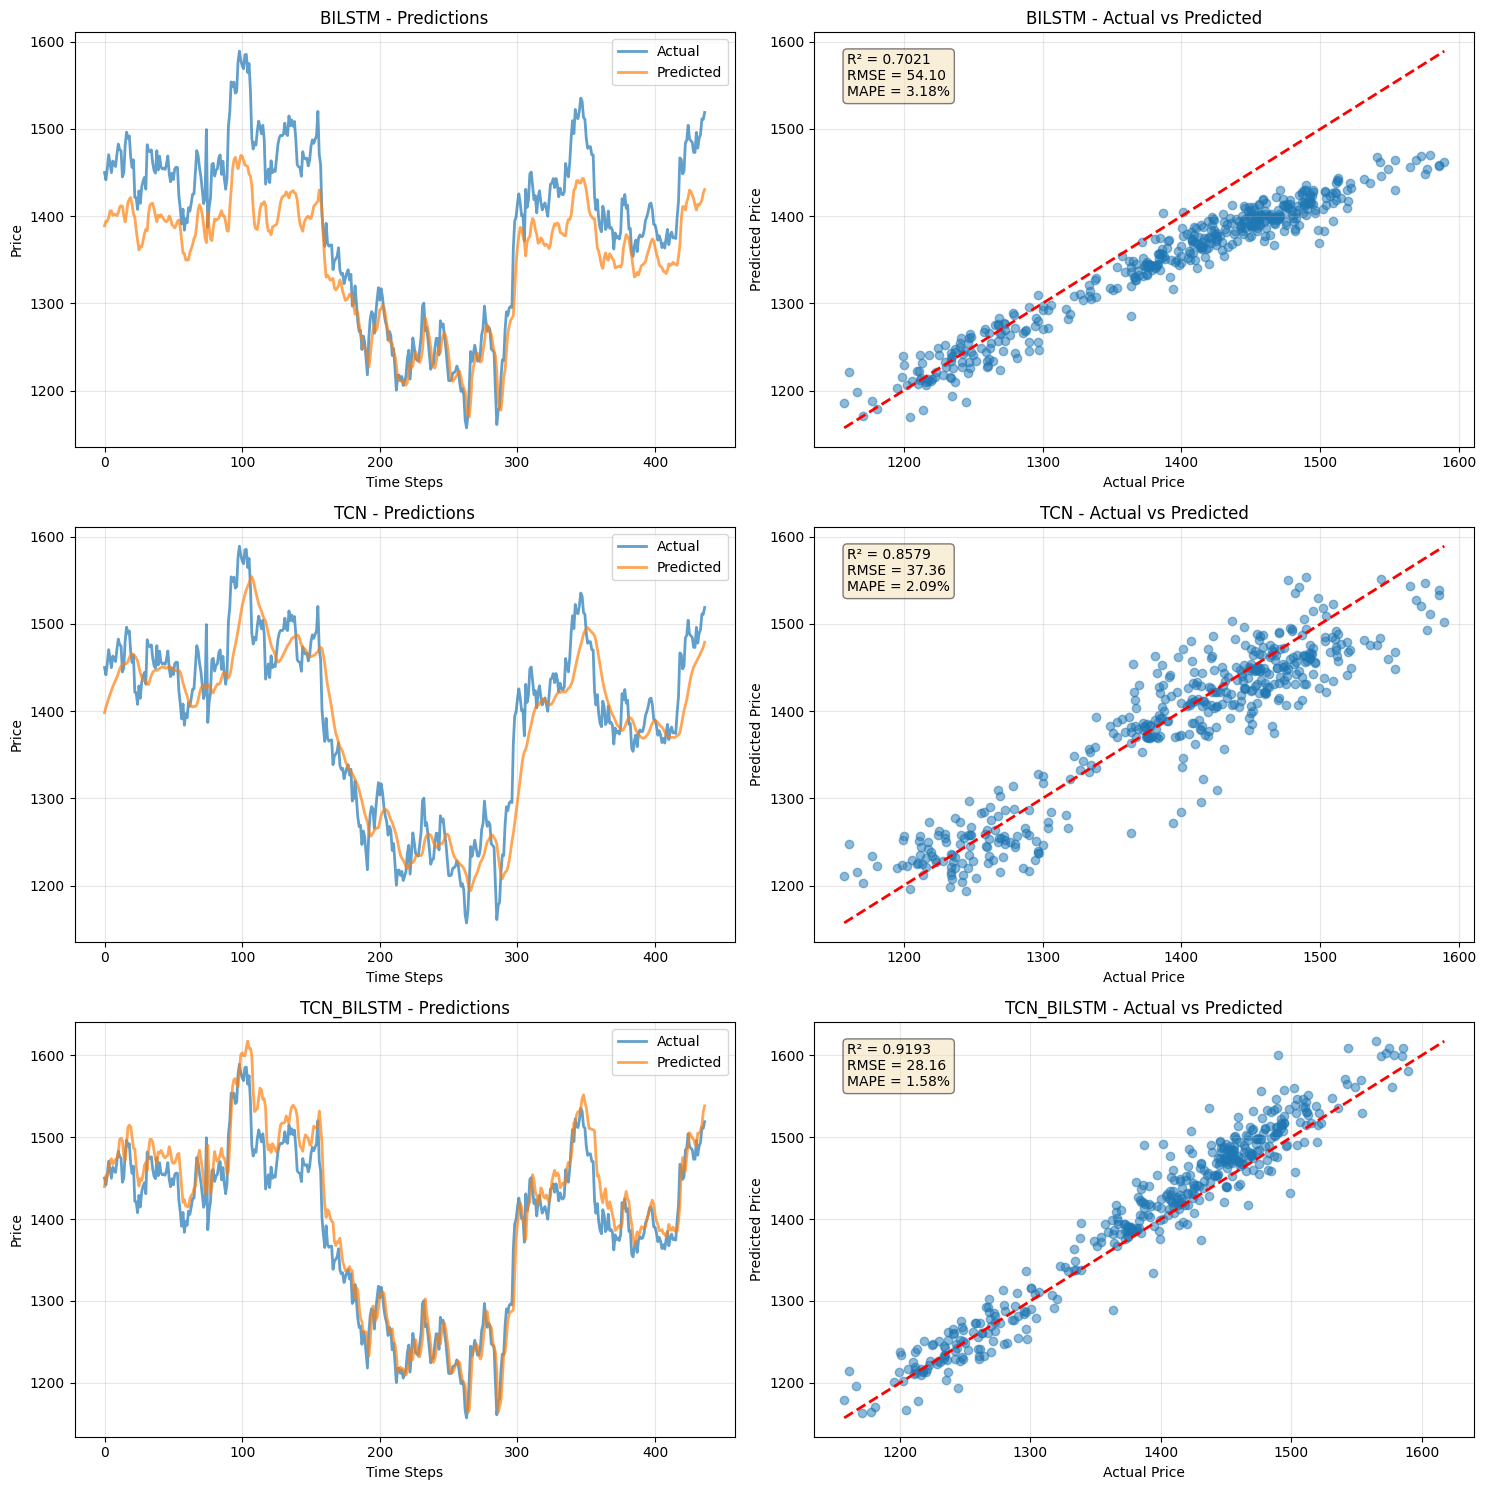


✓ Done!
  Predictions saved to: prediction/reliance/
  Models saved to: saved_models/reliance/


In [ ]:
# Colab-ready: NSE Stock Price Prediction Pipeline (Price Data Only)
# Fixed version - handles NaN values and focuses on price dataset
#
# Usage (Colab):
# 1) Paste this cell, run it.
# 2) After setup finishes run:
#    models, histories, tests = train_nse("reliance", window=20, batch=32, epochs=30)
#    results = evaluate_models(models, tests)
#    plot_results(results)
# ------------------------------------------------------------------------------

# Install dependencies (Colab)
!pip install -q yfinance pandas matplotlib tensorflow

# ------------------------------------------------------------------------------

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------
# Utilities & metrics
# ----------------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ----------------------------
# Filenames
# ----------------------------
def candidate_paths(stock):
    s = stock.lower()
    base = f"data/{s}"
    # old Indonesian names
    old_price = f"{base}/data_harga_{s}.csv"
    # new NSE names
    new_price = f"{base}/price_data_{s}.csv"
    return dict(price_old=old_price, price_new=new_price, base=base)

# ----------------------------
# Price fetcher (yfinance) for NSE tickers
# ----------------------------
def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS",
        "tcs": "TCS.NS",
        "infosys": "INFY.NS",
        "hdfc": "HDFCBANK.NS"
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")
    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")
    print(f"Fetching {ticker} from yfinance {start} → {end}")
    t = yf.Ticker(ticker)
    try:
        history = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print("yfinance fetch error:", e)
        history = pd.DataFrame()
    if history.empty:
        return history
    history = history.reset_index().rename(columns={"Date": "Date"})
    return history

# ----------------------------
# Safe loader: uses existing CSVs if present, otherwise fetches
# ----------------------------
def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)
    ensure_dir(cp['base'])

    # Check for existing CSV files
    if os.path.exists(cp['price_old']):
        price = pd.read_csv(cp['price_old'])
        print("Loaded price from", cp['price_old'])
    elif os.path.exists(cp['price_new']):
        price = pd.read_csv(cp['price_new'])
        print("Loaded price from", cp['price_new'])
    else:
        price = fetch_price_yf(stock, start="2014-01-01")
        if price.empty:
            print("[WARNING] yfinance failed — creating placeholder price data")
            idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
            price = pd.DataFrame({
                'Date': idx,
                'Open': 100 + np.cumsum(np.random.randn(len(idx)) * 2),
                'High': 105 + np.cumsum(np.random.randn(len(idx)) * 2),
                'Low': 95 + np.cumsum(np.random.randn(len(idx)) * 2),
                'Close': 100 + np.cumsum(np.random.randn(len(idx)) * 2),
                'Volume': np.random.randint(1000000, 10000000, size=len(idx))
            })
        price.to_csv(cp['price_new'], index=False)
        print("Saved price to", cp['price_new'])

    return price

# ----------------------------
# Data preprocessing with NaN handling
# ----------------------------
def preprocess_price_data(df):
    """Clean and prepare price data"""
    # Keep only numeric columns we need
    columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
    available_cols = [col for col in columns_to_keep if col in df.columns]

    if not available_cols:
        raise ValueError("No usable price columns found in dataframe")

    # Create clean dataframe
    clean_df = df[available_cols].copy()

    # Handle any NaN values - forward fill then backward fill
    clean_df = clean_df.ffill().bfill()

    # Drop any remaining rows with NaN (shouldn't be any after ffill/bfill)
    clean_df = clean_df.dropna()

    # Ensure positive values for volume
    if 'Volume' in clean_df.columns:
        clean_df['Volume'] = clean_df['Volume'].abs()
        # Replace zero volumes with small positive number
        clean_df.loc[clean_df['Volume'] == 0, 'Volume'] = 1

    print(f"Data shape after cleaning: {clean_df.shape}")
    print(f"Columns: {clean_df.columns.tolist()}")
    print(f"NaN check: {clean_df.isna().sum().sum()} NaN values")

    return clean_df.reset_index(drop=True)

# ----------------------------
# Windowing with proper scaling
# ----------------------------
def make_windows_scaled(df, window_size, target_col='Close'):
    """Create windows with proper scaling"""
    arr = df.copy()

    # Ensure target column exists
    if target_col not in arr.columns:
        target_col = arr.columns[0]

    # Reorder so target is first
    cols = [target_col] + [c for c in arr.columns if c != target_col]
    arr = arr[cols]

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(arr.values)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size, 0])  # Target is first column

    if len(X) == 0:
        return np.empty((0, window_size, arr.shape[1]), dtype=np.float32), \
               np.empty((0, 1), dtype=np.float32), scaler

    return np.array(X, dtype=np.float32), \
           np.array(y, dtype=np.float32).reshape(-1, 1), \
           scaler

def make_tf_dataset(X, y, batch=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(1000, len(X)), seed=42)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Positional encoding layer
# ----------------------------
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

# ----------------------------
# TCN block
# ----------------------------
def tcn_block(x, filters, kernel_size=3, dilation_rate=1, dropout=0.1, final=False):
    y = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    y = LayerNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(dropout)(y)
    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final:
        out = GlobalAveragePooling1D()(out)
    return out

# ----------------------------
# Model builders
# ----------------------------
def build_bilstm(input_shape):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

def build_tcn(input_shape):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = tcn_block(x, filters=64, kernel_size=5, dilation_rate=1, dropout=0.2, final=False)
    x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=2, dropout=0.2, final=False)
    x = tcn_block(x, filters=32, kernel_size=3, dilation_rate=4, dropout=0.2, final=True)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

def build_tcn_bilstm(input_shape):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    # TCN branch
    t = tcn_block(x, filters=32, kernel_size=5, dilation_rate=1, dropout=0.2, final=False)
    t = tcn_block(t, filters=32, kernel_size=3, dilation_rate=2, dropout=0.2, final=True)

    # BiLSTM branch
    b = Bidirectional(LSTM(64, return_sequences=False))(x)
    b = Dropout(0.2)(b)

    # Combine
    c = Concatenate()([t, b])
    c = Dense(32, activation='relu')(c)
    out = Dense(1)(c)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

# ----------------------------
# Training function
# ----------------------------
def train_nse(stock, window=20, batch=32, epochs=200, save_models=True):
    stock = stock.lower()
    print(f"\n{'='*60}")
    print(f"Training models for {stock.upper()}")
    print(f"{'='*60}\n")

    # Load and preprocess data
    price_df = safe_load_price(stock)
    clean_df = preprocess_price_data(price_df)

    # Create directories
    ensure_dir(f"data/{stock}")
    ensure_dir(f"prediction/{stock}")
    ensure_dir(f"saved_models/{stock}")

    # Prepare windows with scaling
    X, y, scaler = make_windows_scaled(clean_df, window)

    if X.shape[0] < 100:
        raise ValueError(f"Not enough data points. Got {X.shape[0]}, need at least 100")

    print(f"\nData prepared:")
    print(f"  Total samples: {X.shape[0]}")
    print(f"  Window size: {window}")
    print(f"  Features: {X.shape[2]}")

    # Split train/val/test (70/15/15)
    n = len(X)
    i1 = int(0.7 * n)
    i2 = int(0.85 * n)

    X_train, y_train = X[:i1], y[:i1]
    X_val, y_val = X[i1:i2], y[i1:i2]
    X_test, y_test = X[i2:], y[i2:]

    print(f"\nData split:")
    print(f"  Train: {len(X_train)} samples")
    print(f"  Val: {len(X_val)} samples")
    print(f"  Test: {len(X_test)} samples")

    # Create TF datasets
    train_ds = make_tf_dataset(X_train, y_train, batch=batch, shuffle=True)
    val_ds = make_tf_dataset(X_val, y_val, batch=batch, shuffle=False)

    # Build models
    shape = (window, X.shape[2])

    models = {}
    histories = {}

    # Train BiLSTM
    print(f"\n{'-'*60}")
    print("Training BiLSTM model...")
    print(f"{'-'*60}")
    m_bilstm = build_bilstm(shape)
    h1 = m_bilstm.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)
        ]
    )
    models['bilstm'] = m_bilstm
    histories['bilstm'] = h1

    # Train TCN
    print(f"\n{'-'*60}")
    print("Training TCN model...")
    print(f"{'-'*60}")
    m_tcn = build_tcn(shape)
    h2 = m_tcn.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)
        ]
    )
    models['tcn'] = m_tcn
    histories['tcn'] = h2

    # Train TCN-BiLSTM
    print(f"\n{'-'*60}")
    print("Training TCN-BiLSTM hybrid model...")
    print(f"{'-'*60}")
    m_tcnb = build_tcn_bilstm(shape)
    h3 = m_tcnb.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)
        ]
    )
    models['tcn_bilstm'] = m_tcnb
    histories['tcn_bilstm'] = h3

    # Save models
    if save_models:
        for model_name, model in models.items():
            model_dir = f"saved_models/{stock}/{model_name}"
            ensure_dir(model_dir)
            model.save(f"{model_dir}/model.keras")
            print(f"Saved {model_name} model")

    # Store test set and scaler
    test_sets = {
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scaler
    }

    print(f"\n{'='*60}")
    print("Training completed!")
    print(f"{'='*60}\n")

    return models, histories, test_sets

# ----------------------------
# Evaluation
# ----------------------------
def evaluate_models(models, test_sets, stock='reliance'):
    X_test = test_sets['X_test']
    y_test = test_sets['y_test']
    scaler = test_sets['scaler']

    ensure_dir(f"prediction/{stock}")

    results = {}
    print(f"\n{'='*60}")
    print("Model Evaluation Results")
    print(f"{'='*60}\n")

    for model_name, model in models.items():
        print(f"{model_name.upper()}:")

        # Predict
        y_pred_scaled = model.predict(X_test, verbose=0)

        # Inverse transform predictions and true values
        # Create dummy array for inverse transform
        dummy = np.zeros((len(y_test), scaler.n_features_in_))
        dummy[:, 0] = y_test.flatten()
        y_true_unscaled = scaler.inverse_transform(dummy)[:, 0]

        dummy[:, 0] = y_pred_scaled.flatten()
        y_pred_unscaled = scaler.inverse_transform(dummy)[:, 0]

        # Calculate metrics
        mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
        mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
        rmse_val = math.sqrt(mse)
        r2 = r2_score(y_true_unscaled, y_pred_unscaled)
        mape = np.mean(np.abs((y_true_unscaled - y_pred_unscaled) / y_true_unscaled)) * 100

        results[model_name] = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse_val,
            'r2': r2,
            'mape': mape,
            'y_true': y_true_unscaled,
            'y_pred': y_pred_unscaled
        }

        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse_val:.2f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print()

        # Save predictions
        pred_df = pd.DataFrame({
            'y_true': y_true_unscaled,
            'y_pred': y_pred_unscaled,
            'error': y_true_unscaled - y_pred_unscaled
        })
        pred_df.to_csv(f"prediction/{stock}/{model_name}_predictions.csv", index=False)

    print(f"{'='*60}\n")
    return results

# ----------------------------
# Plotting
# ----------------------------
def plot_results(results):
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 2, figsize=(15, 5*n_models))

    if n_models == 1:
        axes = axes.reshape(1, -1)

    for idx, (model_name, data) in enumerate(results.items()):
        # Plot predictions
        ax1 = axes[idx, 0]
        ax1.plot(data['y_true'], label='Actual', linewidth=2, alpha=0.7)
        ax1.plot(data['y_pred'], label='Predicted', linewidth=2, alpha=0.7)
        ax1.set_title(f'{model_name.upper()} - Predictions')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Price')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot scatter
        ax2 = axes[idx, 1]
        ax2.scatter(data['y_true'], data['y_pred'], alpha=0.5)
        min_val = min(data['y_true'].min(), data['y_pred'].min())
        max_val = max(data['y_true'].max(), data['y_pred'].max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax2.set_title(f'{model_name.upper()} - Actual vs Predicted')
        ax2.set_xlabel('Actual Price')
        ax2.set_ylabel('Predicted Price')
        ax2.grid(True, alpha=0.3)

        # Add metrics text
        metrics_text = f"R² = {data['r2']:.4f}\nRMSE = {data['rmse']:.2f}\nMAPE = {data['mape']:.2f}%"
        ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

def plot_training_history(histories):
    """Plot training and validation loss"""
    n_models = len(histories)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 4))

    if n_models == 1:
        axes = [axes]

    for idx, (model_name, history) in enumerate(histories.items()):
        axes[idx].plot(history.history['loss'], label='Train Loss')
        axes[idx].plot(history.history['val_loss'], label='Val Loss')
        axes[idx].set_title(f'{model_name.upper()} - Training History')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Loss')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ----------------------------
# Main execution
# ----------------------------
if __name__ == "__main__":
    # Configuration
    STOCK = "reliance"
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    EPOCHS = 200

    # Train models
    models, histories, test_sets = train_nse(
        stock=STOCK,
        window=WINDOW_SIZE,
        batch=BATCH_SIZE,
        epochs=EPOCHS
    )

    # Evaluate
    results = evaluate_models(models, test_sets, stock=STOCK)

    # Plot results
    plot_training_history(histories)
    plot_results(results)

    print("\n✓ Done!")
    print(f"  Predictions saved to: prediction/{STOCK}/")
    print(f"  Models saved to: saved_models/{STOCK}/")


Training models for RELIANCE

Loaded price from data/reliance/price_data_reliance.csv
Data shape after cleaning: (2929, 5)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
NaN check: 0 NaN values

Data prepared:
  Total samples: 2909
  Window size: 20
  Features: 5

Data split:
  Train: 2036 samples
  Val: 436 samples
  Test: 437 samples

------------------------------------------------------------
Training BiLSTM model...
------------------------------------------------------------
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - calc_r2_score: -2.4890 - loss: 0.0064 - mae: 0.0590 - mse: 0.0064 - rmse: 0.0706 - val_calc_r2_score: -24.1699 - val_loss: 0.0100 - val_mae: 0.0948 - val_mse: 0.0100 - val_rmse: 0.0991 - learning_rate: 0.0010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - calc_r2_score: 0.9159 - loss: 8.7801e-04 - mae: 0.0213 - mse: 8.7801e-04 - rmse: 0.0285 - val_calc_r2_score: -14.2198 - val_loss: 0.0061 - val_mae: 0.0721 - val_mse: 0.0061 - val_rmse: 0.0770

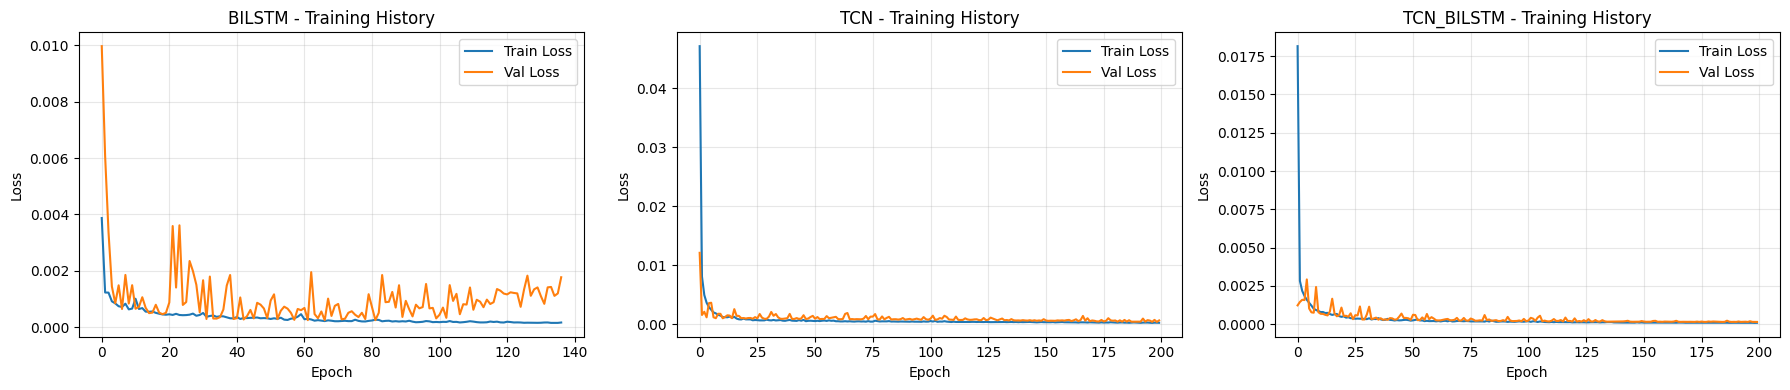

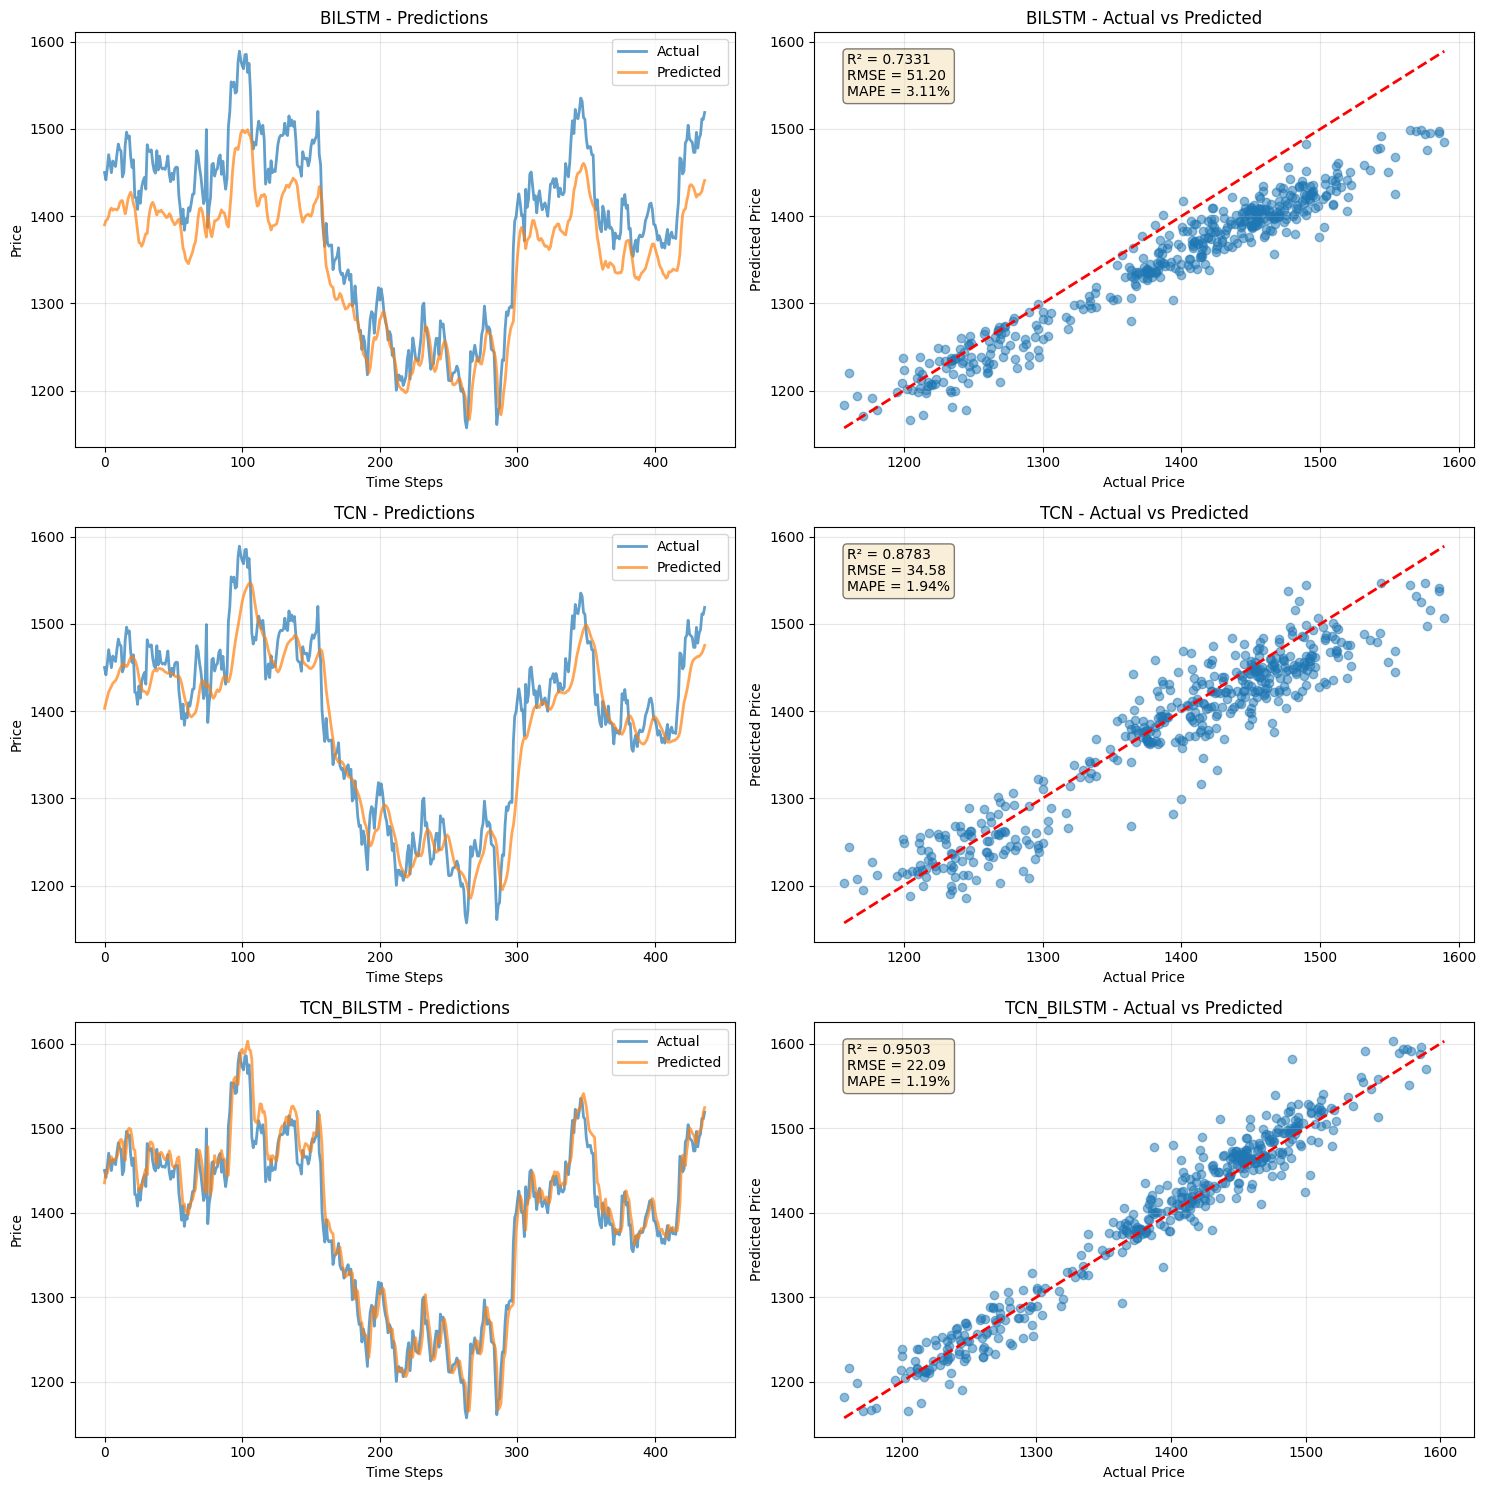


Training models for TCS

Fetching TCS.NS from yfinance 2014-01-01 → 2025-11-15
Saved price to data/tcs/price_data_tcs.csv
Data shape after cleaning: (2929, 5)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
NaN check: 0 NaN values

Data prepared:
  Total samples: 2909
  Window size: 20
  Features: 5

Data split:
  Train: 2036 samples
  Val: 436 samples
  Test: 437 samples

------------------------------------------------------------
Training BiLSTM model...
------------------------------------------------------------
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - calc_r2_score: -6.5197 - loss: 0.0078 - mae: 0.0644 - mse: 0.0078 - rmse: 0.0770 - val_calc_r2_score: -0.6325 - val_loss: 9.9108e-04 - val_mae: 0.0251 - val_mse: 9.9108e-04 - val_rmse: 0.0301 - learning_rate: 0.0010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - calc_r2_score: 0.8086 - loss: 9.6655e-04 - mae: 0.0227 - mse: 9.6655e-04 - rmse: 0.0293 - val_calc_r2_score: -0.7177 - val_loss: 9.3908e-04 - val_ma

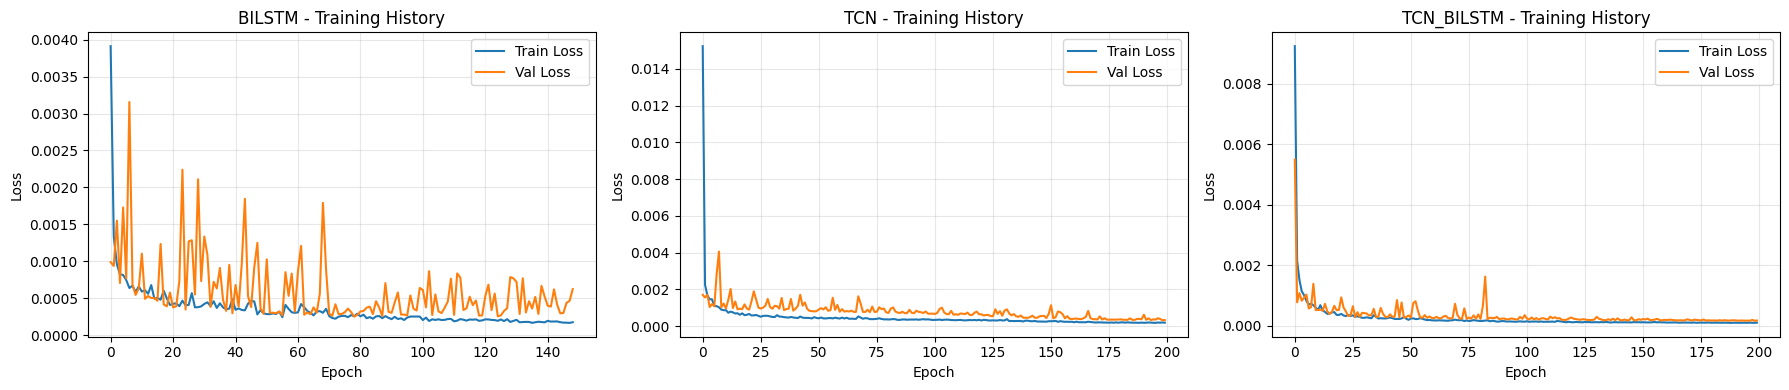

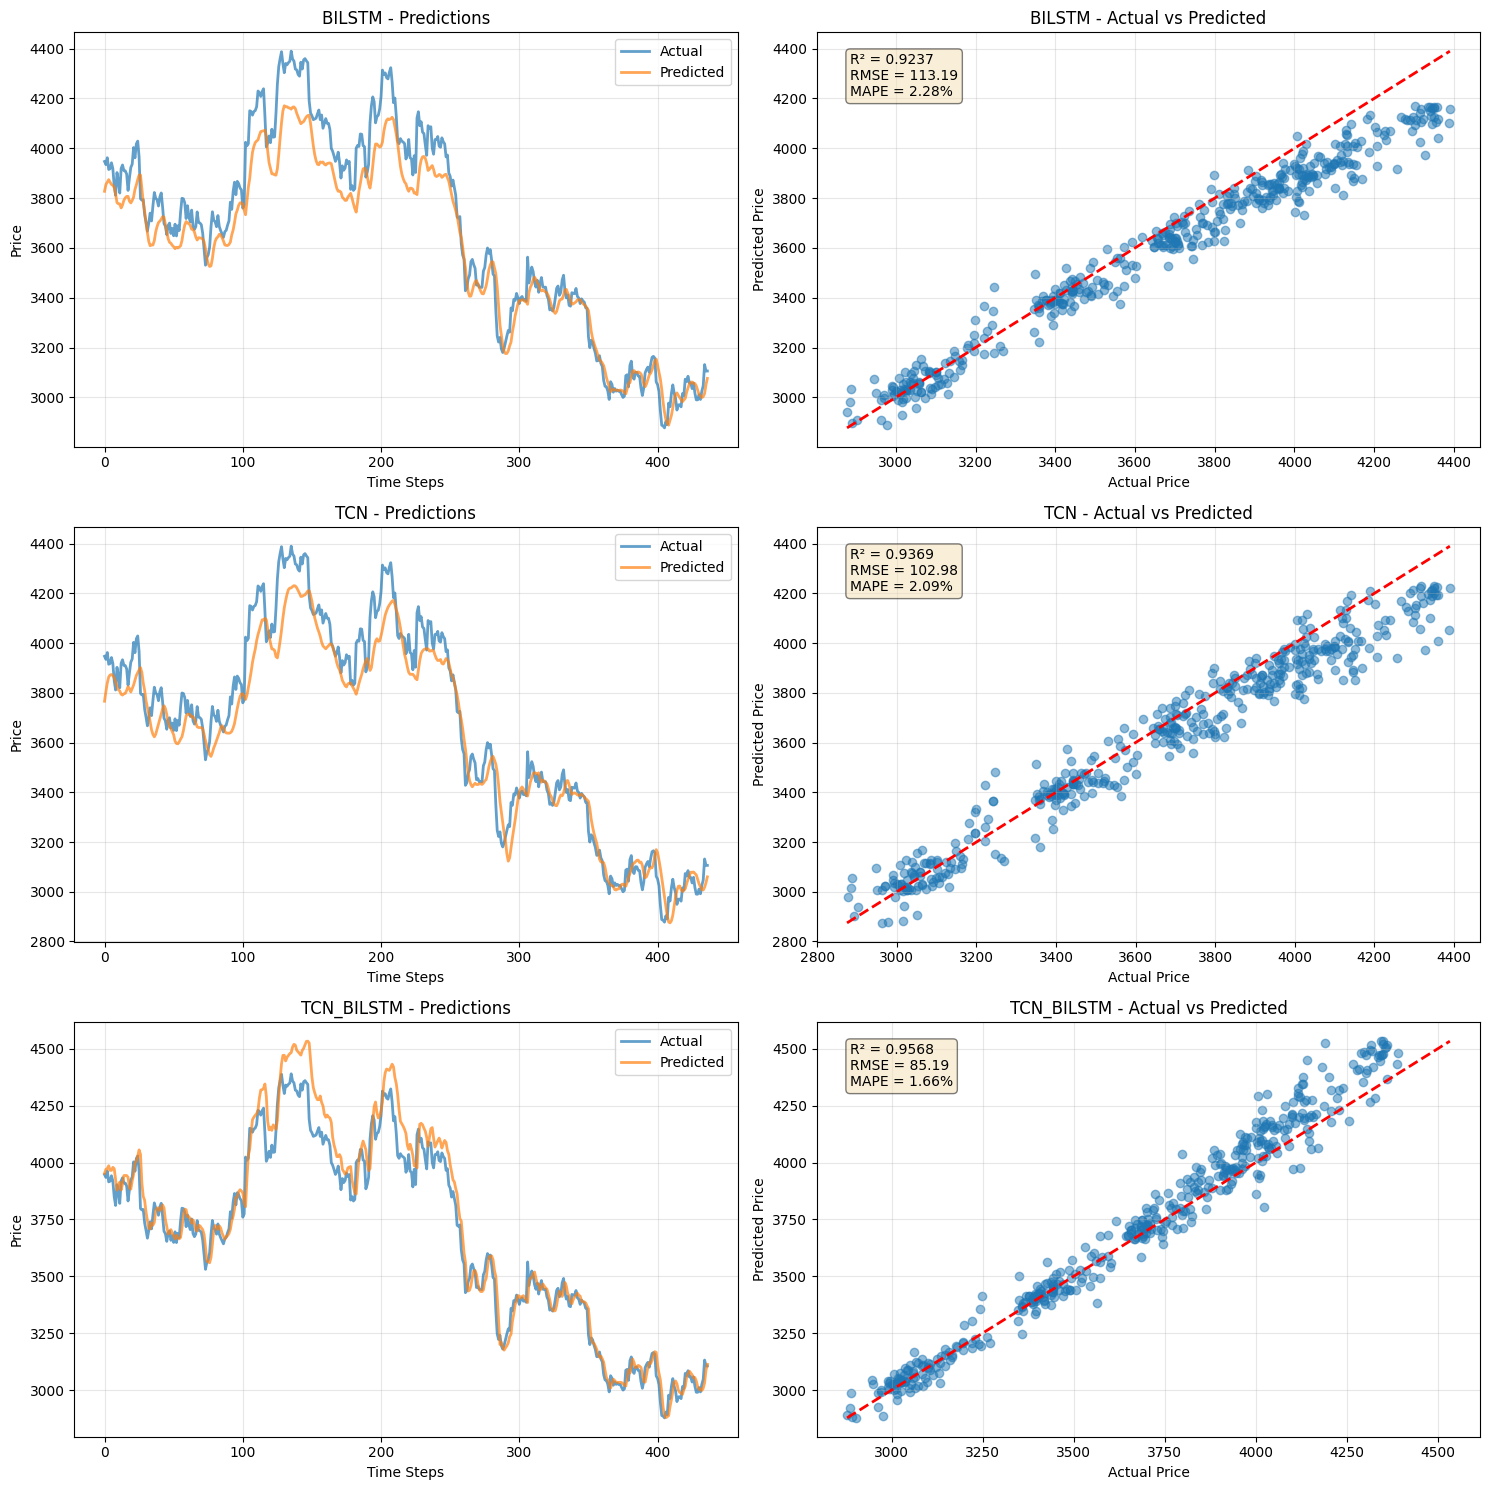


Training models for HDFC

Fetching HDFCBANK.NS from yfinance 2014-01-01 → 2025-11-15
Saved price to data/hdfc/price_data_hdfc.csv
Data shape after cleaning: (2929, 5)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
NaN check: 0 NaN values

Data prepared:
  Total samples: 2909
  Window size: 20
  Features: 5

Data split:
  Train: 2036 samples
  Val: 436 samples
  Test: 437 samples

------------------------------------------------------------
Training BiLSTM model...
------------------------------------------------------------
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - calc_r2_score: 0.2431 - loss: 0.0086 - mae: 0.0698 - mse: 0.0086 - rmse: 0.0858 - val_calc_r2_score: -11.4661 - val_loss: 0.0029 - val_mae: 0.0478 - val_mse: 0.0029 - val_rmse: 0.0511 - learning_rate: 0.0010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - calc_r2_score: 0.9543 - loss: 9.8292e-04 - mae: 0.0231 - mse: 9.8292e-04 - rmse: 0.0304 - val_calc_r2_score: -6.8151 - val_loss: 0.0018 - val_mae: 0

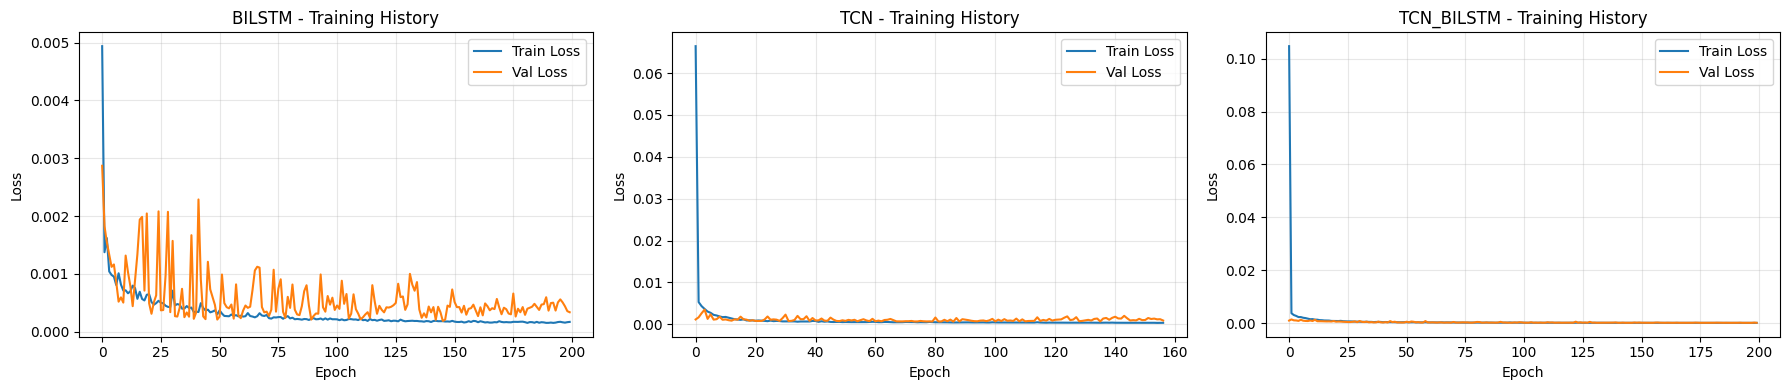

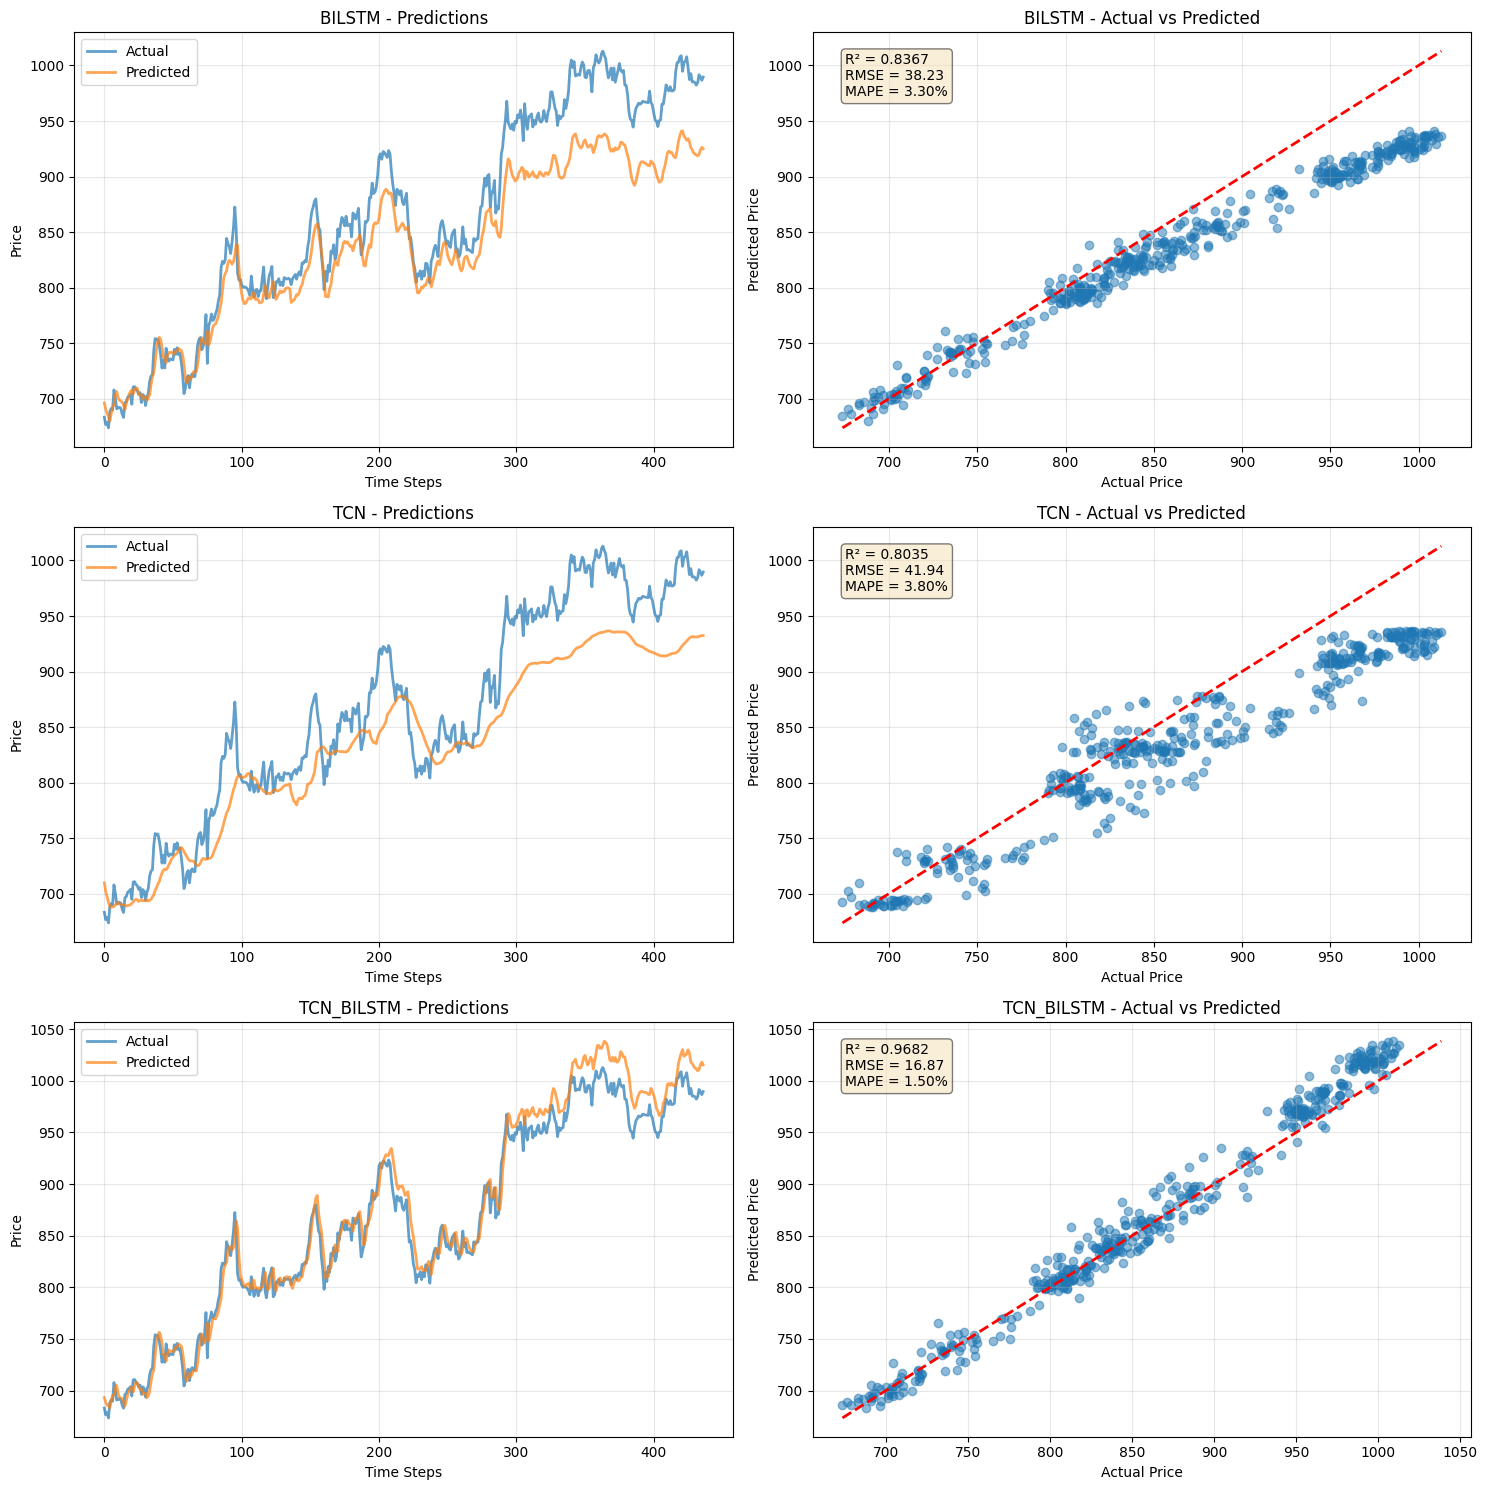


Training models for INFOSYS

Fetching INFY.NS from yfinance 2014-01-01 → 2025-11-15
Saved price to data/infosys/price_data_infosys.csv
Data shape after cleaning: (2929, 5)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
NaN check: 0 NaN values

Data prepared:
  Total samples: 2909
  Window size: 20
  Features: 5

Data split:
  Train: 2036 samples
  Val: 436 samples
  Test: 437 samples

------------------------------------------------------------
Training BiLSTM model...
------------------------------------------------------------
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - calc_r2_score: -2.9505 - loss: 0.0064 - mae: 0.0606 - mse: 0.0064 - rmse: 0.0729 - val_calc_r2_score: -1.0295 - val_loss: 0.0015 - val_mae: 0.0305 - val_mse: 0.0015 - val_rmse: 0.0359 - learning_rate: 0.0010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - calc_r2_score: 0.7184 - loss: 7.6450e-04 - mae: 0.0203 - mse: 7.6450e-04 - rmse: 0.0261 - val_calc_r2_score: -0.3412 - val_loss: 0.0010 - val_m

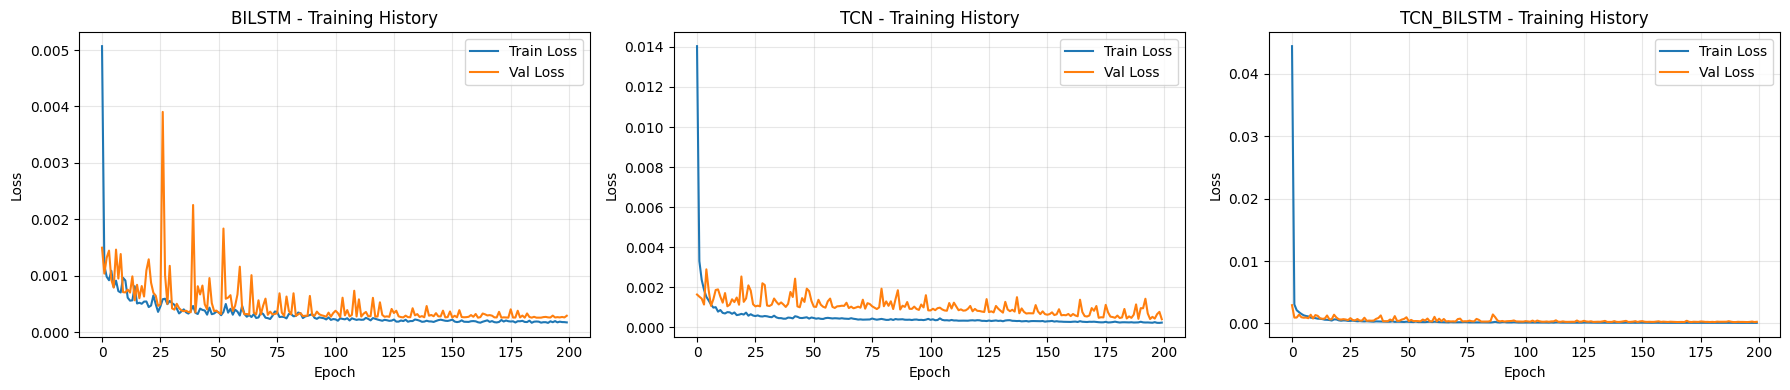

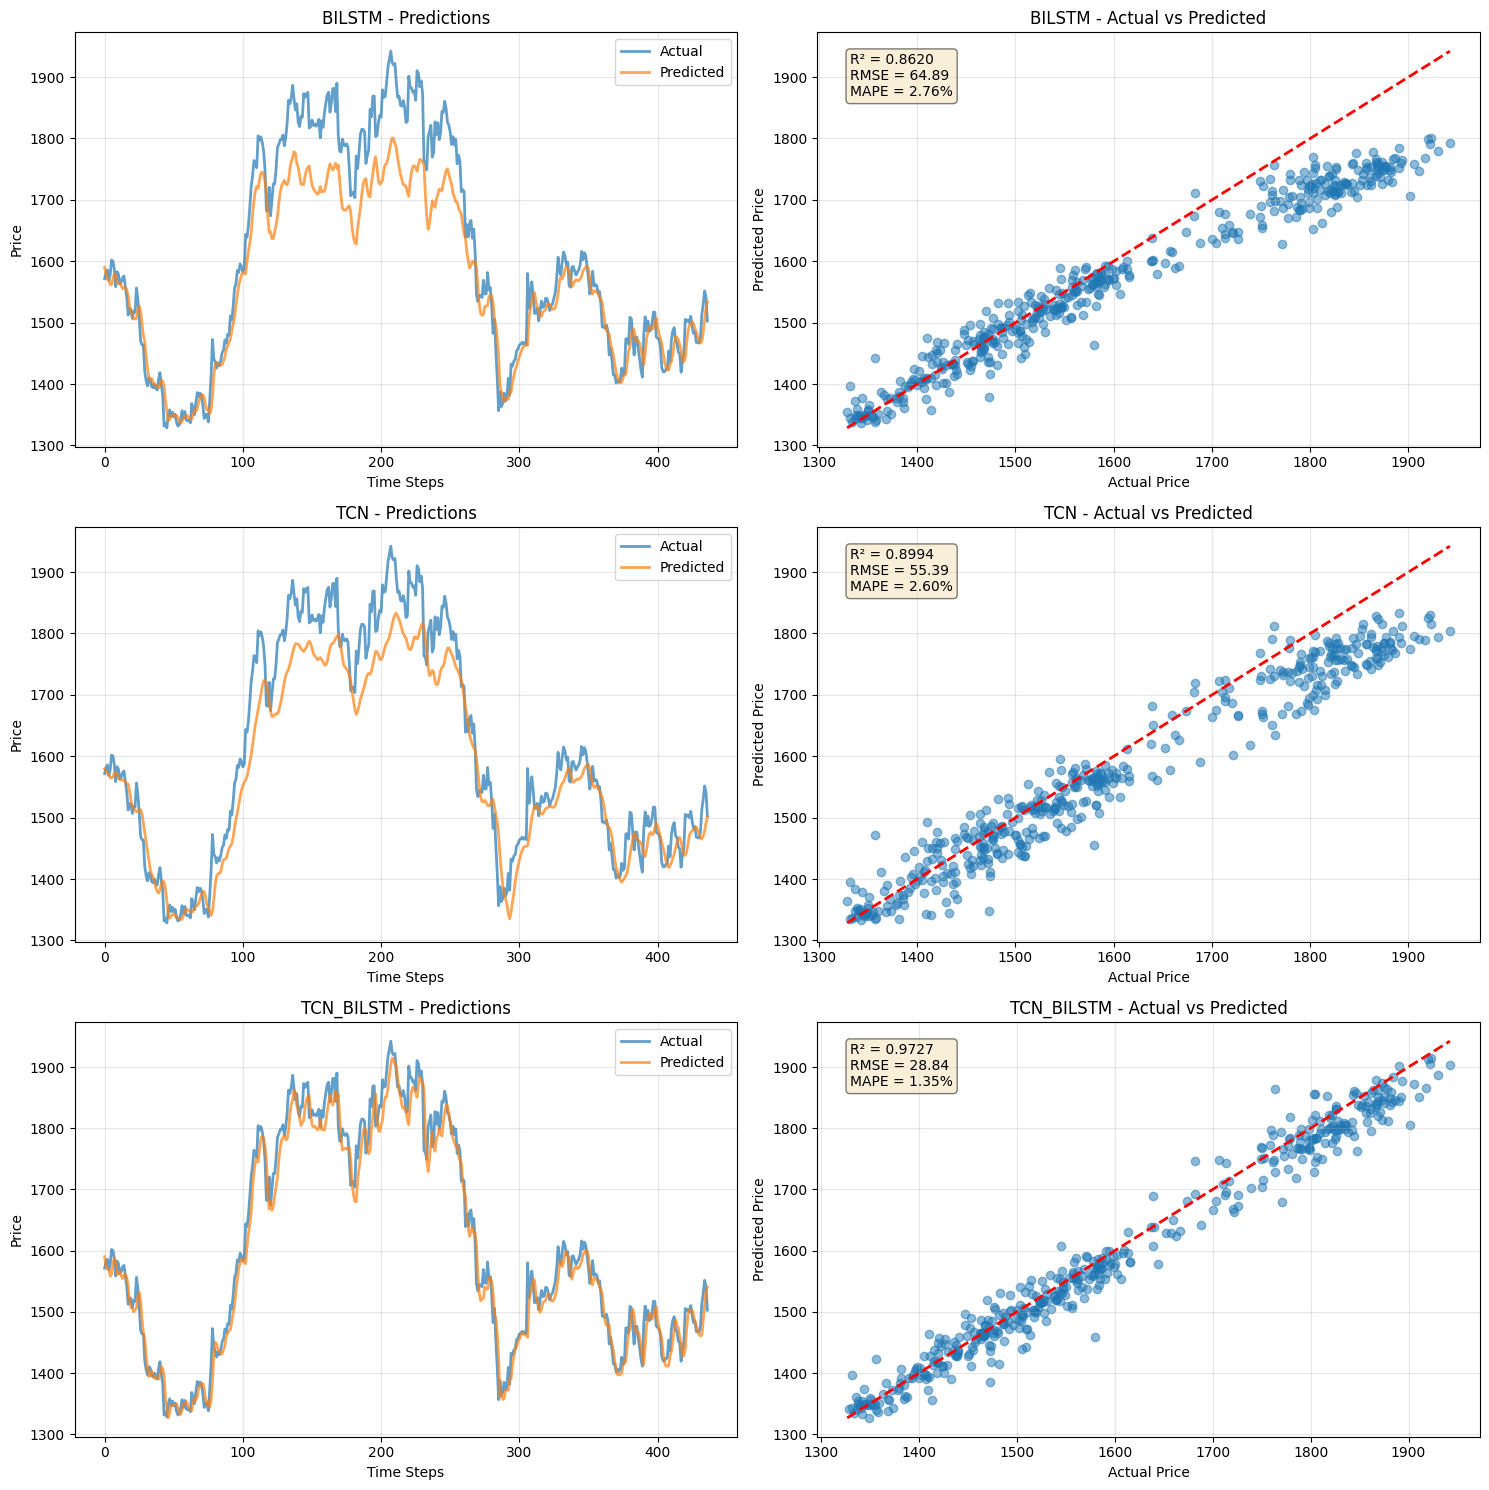


Training models for ICICI

Fetching ICICIBANK.NS from yfinance 2014-01-01 → 2025-11-15
Saved price to data/icici/price_data_icici.csv
Data shape after cleaning: (2929, 5)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
NaN check: 0 NaN values

Data prepared:
  Total samples: 2909
  Window size: 20
  Features: 5

Data split:
  Train: 2036 samples
  Val: 436 samples
  Test: 437 samples

------------------------------------------------------------
Training BiLSTM model...
------------------------------------------------------------
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - calc_r2_score: -8.8378 - loss: 0.0087 - mae: 0.0654 - mse: 0.0087 - rmse: 0.0747 - val_calc_r2_score: -2.3515 - val_loss: 5.7826e-04 - val_mae: 0.0193 - val_mse: 5.7826e-04 - val_rmse: 0.0221 - learning_rate: 0.0010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - calc_r2_score: 0.7291 - loss: 5.1634e-04 - mae: 0.0170 - mse: 5.1634e-04 - rmse: 0.0219 - val_calc_r2_score: -0.8705 - val_loss: 3.9433e

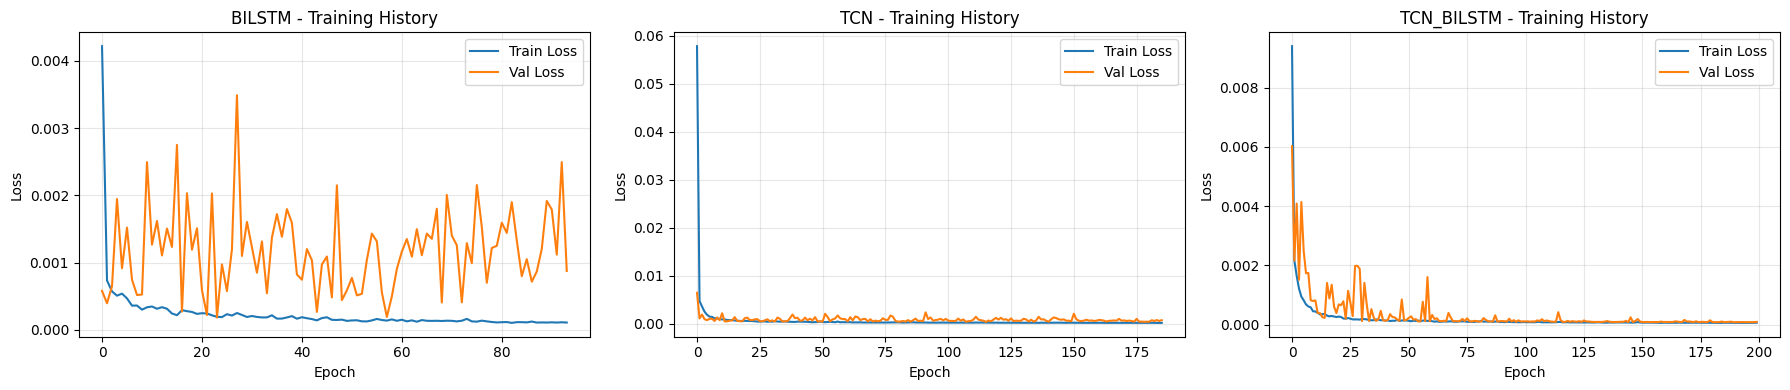

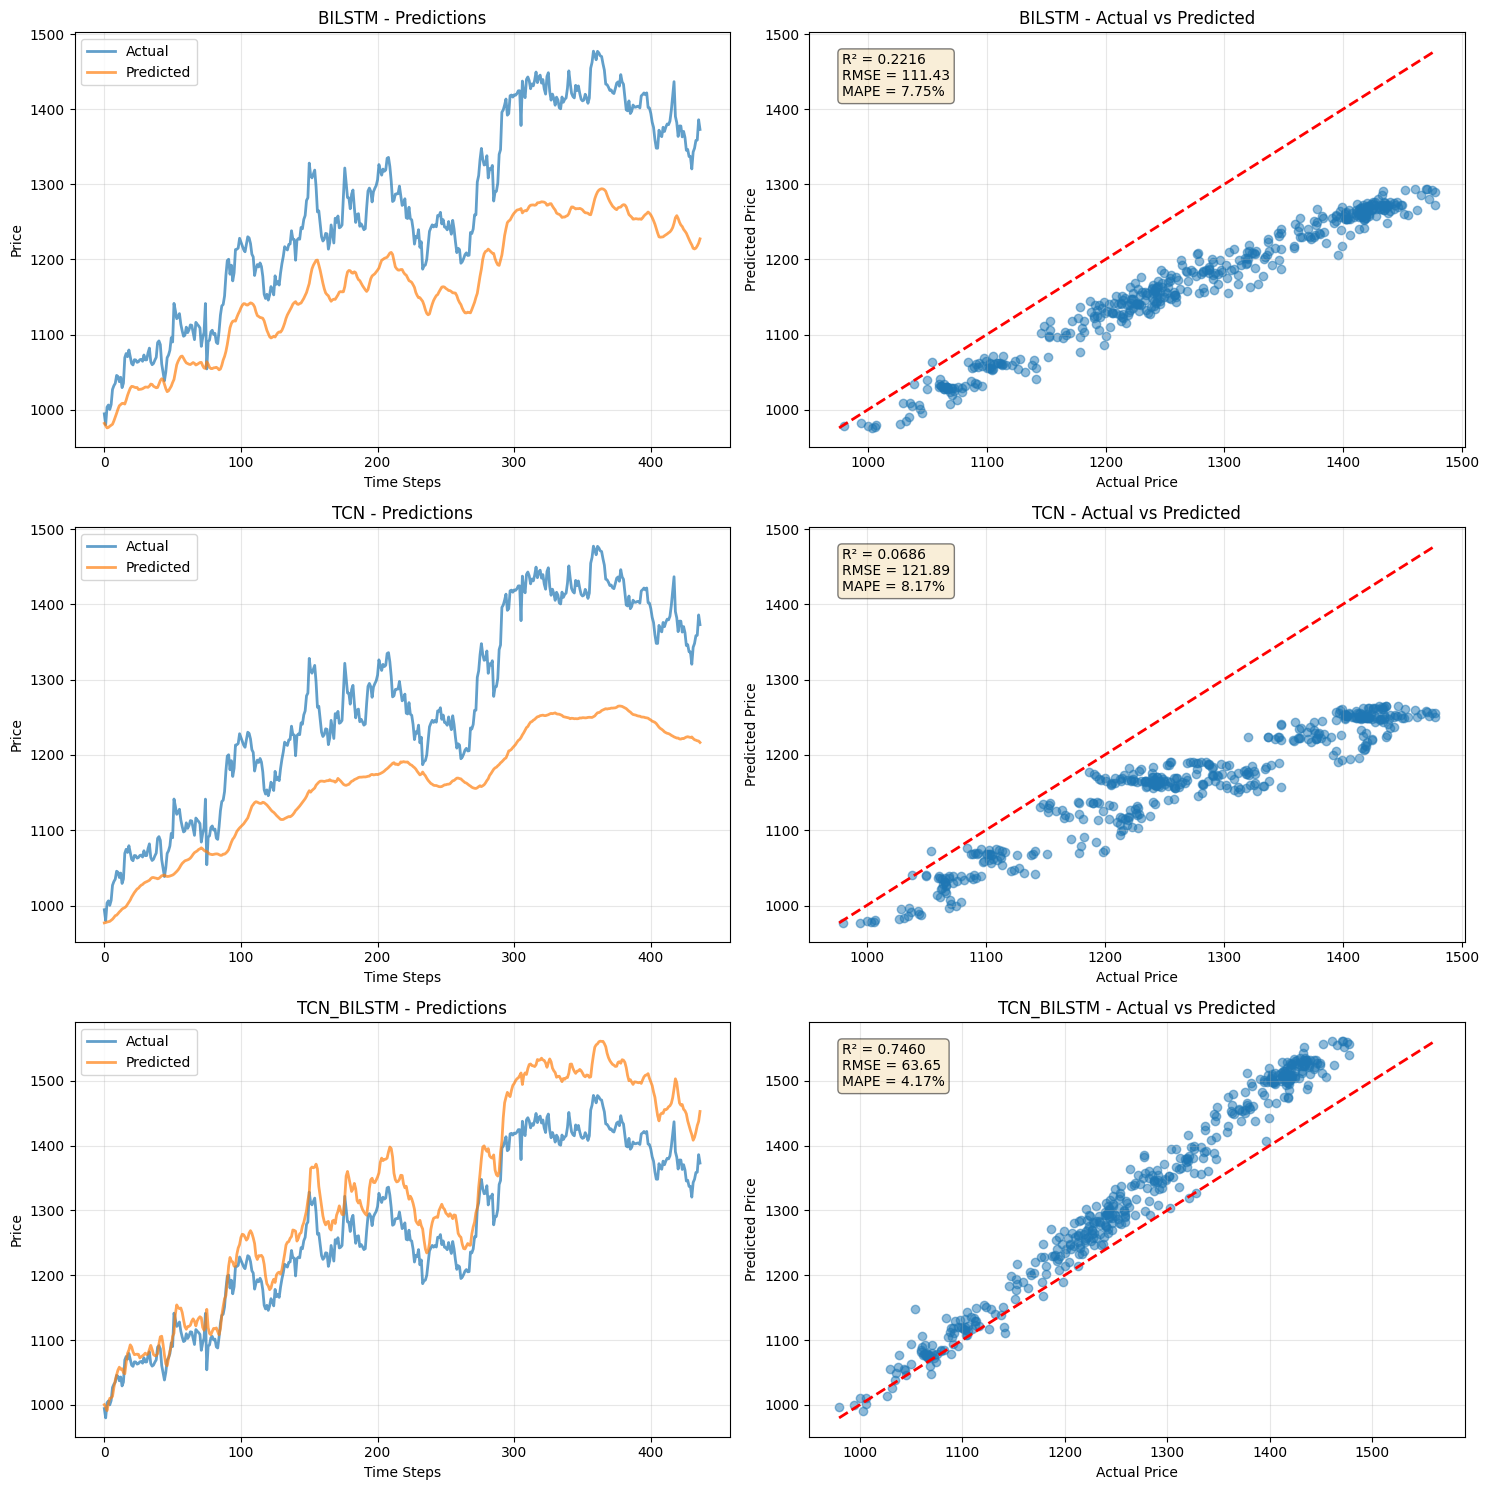


✓ Done!
All predictions saved in: prediction/<stock>/
All models saved in: saved_models/<stock>/


In [ ]:
# Colab-ready: NSE Stock Price Prediction Pipeline (Price Data Only)
# Fixed version - handles NaN values and focuses on price dataset
#
# Usage (Colab):
# 1) Paste this cell, run it.
# 2) After setup finishes run:
#    models, histories, tests = train_nse("reliance", window=20, batch=32, epochs=30)
#    results = evaluate_models(models, tests)
#    plot_results(results)
# ------------------------------------------------------------------------------

# Install dependencies (Colab)
!pip install -q yfinance pandas matplotlib tensorflow

# ------------------------------------------------------------------------------

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------
# Utilities & metrics
# ----------------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ----------------------------
# Filenames
# ----------------------------
def candidate_paths(stock):
    s = stock.lower()
    base = f"data/{s}"
    # old Indonesian names
    old_price = f"{base}/data_harga_{s}.csv"
    # new NSE names
    new_price = f"{base}/price_data_{s}.csv"
    return dict(price_old=old_price, price_new=new_price, base=base)

# ----------------------------
# Price fetcher (yfinance) for NSE tickers
# ----------------------------
def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS",
        "tcs": "TCS.NS",
        "infosys": "INFY.NS",
        "hdfc": "HDFCBANK.NS"
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")
    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")
    print(f"Fetching {ticker} from yfinance {start} → {end}")
    t = yf.Ticker(ticker)
    try:
        history = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print("yfinance fetch error:", e)
        history = pd.DataFrame()
    if history.empty:
        return history
    history = history.reset_index().rename(columns={"Date": "Date"})
    return history

# ----------------------------
# Safe loader: uses existing CSVs if present, otherwise fetches
# ----------------------------
def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)
    ensure_dir(cp['base'])

    # Check for existing CSV files
    if os.path.exists(cp['price_old']):
        price = pd.read_csv(cp['price_old'])
        print("Loaded price from", cp['price_old'])
    elif os.path.exists(cp['price_new']):
        price = pd.read_csv(cp['price_new'])
        print("Loaded price from", cp['price_new'])
    else:
        price = fetch_price_yf(stock, start="2014-01-01")
        if price.empty:
            print("[WARNING] yfinance failed — creating placeholder price data")
            idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
            price = pd.DataFrame({
                'Date': idx,
                'Open': 100 + np.cumsum(np.random.randn(len(idx)) * 2),
                'High': 105 + np.cumsum(np.random.randn(len(idx)) * 2),
                'Low': 95 + np.cumsum(np.random.randn(len(idx)) * 2),
                'Close': 100 + np.cumsum(np.random.randn(len(idx)) * 2),
                'Volume': np.random.randint(1000000, 10000000, size=len(idx))
            })
        price.to_csv(cp['price_new'], index=False)
        print("Saved price to", cp['price_new'])

    return price

# ----------------------------
# Data preprocessing with NaN handling
# ----------------------------
def preprocess_price_data(df):
    """Clean and prepare price data"""
    # Keep only numeric columns we need
    columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
    available_cols = [col for col in columns_to_keep if col in df.columns]

    if not available_cols:
        raise ValueError("No usable price columns found in dataframe")

    # Create clean dataframe
    clean_df = df[available_cols].copy()

    # Handle any NaN values - forward fill then backward fill
    clean_df = clean_df.ffill().bfill()

    # Drop any remaining rows with NaN (shouldn't be any after ffill/bfill)
    clean_df = clean_df.dropna()

    # Ensure positive values for volume
    if 'Volume' in clean_df.columns:
        clean_df['Volume'] = clean_df['Volume'].abs()
        # Replace zero volumes with small positive number
        clean_df.loc[clean_df['Volume'] == 0, 'Volume'] = 1

    print(f"Data shape after cleaning: {clean_df.shape}")
    print(f"Columns: {clean_df.columns.tolist()}")
    print(f"NaN check: {clean_df.isna().sum().sum()} NaN values")

    return clean_df.reset_index(drop=True)

# ----------------------------
# Windowing with proper scaling
# ----------------------------
def make_windows_scaled(df, window_size, target_col='Close'):
    """Create windows with proper scaling"""
    arr = df.copy()

    # Ensure target column exists
    if target_col not in arr.columns:
        target_col = arr.columns[0]

    # Reorder so target is first
    cols = [target_col] + [c for c in arr.columns if c != target_col]
    arr = arr[cols]

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(arr.values)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size, 0])  # Target is first column

    if len(X) == 0:
        return np.empty((0, window_size, arr.shape[1]), dtype=np.float32), \
               np.empty((0, 1), dtype=np.float32), scaler

    return np.array(X, dtype=np.float32), \
           np.array(y, dtype=np.float32).reshape(-1, 1), \
           scaler

def make_tf_dataset(X, y, batch=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(1000, len(X)), seed=42)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Positional encoding layer
# ----------------------------
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

# ----------------------------
# TCN block
# ----------------------------
def tcn_block(x, filters, kernel_size=3, dilation_rate=1, dropout=0.1, final=False):
    y = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    y = LayerNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(dropout)(y)
    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final:
        out = GlobalAveragePooling1D()(out)
    return out

# ----------------------------
# Model builders
# ----------------------------
def build_bilstm(input_shape):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

def build_tcn(input_shape):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = tcn_block(x, filters=64, kernel_size=5, dilation_rate=1, dropout=0.2, final=False)
    x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=2, dropout=0.2, final=False)
    x = tcn_block(x, filters=32, kernel_size=3, dilation_rate=4, dropout=0.2, final=True)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

def build_tcn_bilstm(input_shape):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    # TCN branch
    t = tcn_block(x, filters=32, kernel_size=5, dilation_rate=1, dropout=0.2, final=False)
    t = tcn_block(t, filters=32, kernel_size=3, dilation_rate=2, dropout=0.2, final=True)

    # BiLSTM branch
    b = Bidirectional(LSTM(64, return_sequences=False))(x)
    b = Dropout(0.2)(b)

    # Combine
    c = Concatenate()([t, b])
    c = Dense(32, activation='relu')(c)
    out = Dense(1)(c)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

# ----------------------------
# Training function
# ----------------------------
def train_nse(stock, window=20, batch=32, epochs=200, save_models=True):
    stock = stock.lower()
    print(f"\n{'='*60}")
    print(f"Training models for {stock.upper()}")
    print(f"{'='*60}\n")

    # Load and preprocess data
    price_df = safe_load_price(stock)
    clean_df = preprocess_price_data(price_df)

    # Create directories
    ensure_dir(f"data/{stock}")
    ensure_dir(f"prediction/{stock}")
    ensure_dir(f"saved_models/{stock}")

    # Prepare windows with scaling
    X, y, scaler = make_windows_scaled(clean_df, window)

    if X.shape[0] < 100:
        raise ValueError(f"Not enough data points. Got {X.shape[0]}, need at least 100")

    print(f"\nData prepared:")
    print(f"  Total samples: {X.shape[0]}")
    print(f"  Window size: {window}")
    print(f"  Features: {X.shape[2]}")

    # Split train/val/test (70/15/15)
    n = len(X)
    i1 = int(0.7 * n)
    i2 = int(0.85 * n)

    X_train, y_train = X[:i1], y[:i1]
    X_val, y_val = X[i1:i2], y[i1:i2]
    X_test, y_test = X[i2:], y[i2:]

    print(f"\nData split:")
    print(f"  Train: {len(X_train)} samples")
    print(f"  Val: {len(X_val)} samples")
    print(f"  Test: {len(X_test)} samples")

    # Create TF datasets
    train_ds = make_tf_dataset(X_train, y_train, batch=batch, shuffle=True)
    val_ds = make_tf_dataset(X_val, y_val, batch=batch, shuffle=False)

    # Build models
    shape = (window, X.shape[2])

    models = {}
    histories = {}

    # Train BiLSTM
    print(f"\n{'-'*60}")
    print("Training BiLSTM model...")
    print(f"{'-'*60}")
    m_bilstm = build_bilstm(shape)
    h1 = m_bilstm.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)
        ]
    )
    models['bilstm'] = m_bilstm
    histories['bilstm'] = h1

    # Train TCN
    print(f"\n{'-'*60}")
    print("Training TCN model...")
    print(f"{'-'*60}")
    m_tcn = build_tcn(shape)
    h2 = m_tcn.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)
        ]
    )
    models['tcn'] = m_tcn
    histories['tcn'] = h2

    # Train TCN-BiLSTM
    print(f"\n{'-'*60}")
    print("Training TCN-BiLSTM hybrid model...")
    print(f"{'-'*60}")
    m_tcnb = build_tcn_bilstm(shape)
    h3 = m_tcnb.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)
        ]
    )
    models['tcn_bilstm'] = m_tcnb
    histories['tcn_bilstm'] = h3

    # Save models
    if save_models:
        for model_name, model in models.items():
            model_dir = f"saved_models/{stock}/{model_name}"
            ensure_dir(model_dir)
            model.save(f"{model_dir}/model.keras")
            print(f"Saved {model_name} model")

    # Store test set and scaler
    test_sets = {
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scaler
    }

    print(f"\n{'='*60}")
    print("Training completed!")
    print(f"{'='*60}\n")

    return models, histories, test_sets

# ----------------------------
# Evaluation
# ----------------------------
def evaluate_models(models, test_sets, stock='reliance'):
    X_test = test_sets['X_test']
    y_test = test_sets['y_test']
    scaler = test_sets['scaler']

    ensure_dir(f"prediction/{stock}")

    results = {}
    print(f"\n{'='*60}")
    print("Model Evaluation Results")
    print(f"{'='*60}\n")

    for model_name, model in models.items():
        print(f"{model_name.upper()}:")

        # Predict
        y_pred_scaled = model.predict(X_test, verbose=0)

        # Inverse transform predictions and true values
        # Create dummy array for inverse transform
        dummy = np.zeros((len(y_test), scaler.n_features_in_))
        dummy[:, 0] = y_test.flatten()
        y_true_unscaled = scaler.inverse_transform(dummy)[:, 0]

        dummy[:, 0] = y_pred_scaled.flatten()
        y_pred_unscaled = scaler.inverse_transform(dummy)[:, 0]

        # Calculate metrics
        mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
        mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
        rmse_val = math.sqrt(mse)
        r2 = r2_score(y_true_unscaled, y_pred_unscaled)
        mape = np.mean(np.abs((y_true_unscaled - y_pred_unscaled) / y_true_unscaled)) * 100

        results[model_name] = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse_val,
            'r2': r2,
            'mape': mape,
            'y_true': y_true_unscaled,
            'y_pred': y_pred_unscaled
        }

        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse_val:.2f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print()

        # Save predictions
        pred_df = pd.DataFrame({
            'y_true': y_true_unscaled,
            'y_pred': y_pred_unscaled,
            'error': y_true_unscaled - y_pred_unscaled
        })
        pred_df.to_csv(f"prediction/{stock}/{model_name}_predictions.csv", index=False)

    print(f"{'='*60}\n")
    return results

# ----------------------------
# Plotting
# ----------------------------
def plot_results(results):
    n_models = len(results)
    fig, axes = plt.subplots(n_models, 2, figsize=(15, 5*n_models))

    if n_models == 1:
        axes = axes.reshape(1, -1)

    for idx, (model_name, data) in enumerate(results.items()):
        # Plot predictions
        ax1 = axes[idx, 0]
        ax1.plot(data['y_true'], label='Actual', linewidth=2, alpha=0.7)
        ax1.plot(data['y_pred'], label='Predicted', linewidth=2, alpha=0.7)
        ax1.set_title(f'{model_name.upper()} - Predictions')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Price')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot scatter
        ax2 = axes[idx, 1]
        ax2.scatter(data['y_true'], data['y_pred'], alpha=0.5)
        min_val = min(data['y_true'].min(), data['y_pred'].min())
        max_val = max(data['y_true'].max(), data['y_pred'].max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax2.set_title(f'{model_name.upper()} - Actual vs Predicted')
        ax2.set_xlabel('Actual Price')
        ax2.set_ylabel('Predicted Price')
        ax2.grid(True, alpha=0.3)

        # Add metrics text
        metrics_text = f"R² = {data['r2']:.4f}\nRMSE = {data['rmse']:.2f}\nMAPE = {data['mape']:.2f}%"
        ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

def plot_training_history(histories):
    """Plot training and validation loss"""
    n_models = len(histories)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 4))

    if n_models == 1:
        axes = [axes]

    for idx, (model_name, history) in enumerate(histories.items()):
        axes[idx].plot(history.history['loss'], label='Train Loss')
        axes[idx].plot(history.history['val_loss'], label='Val Loss')
        axes[idx].set_title(f'{model_name.upper()} - Training History')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Loss')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ----------------------------
# Main execution
# ----------------------------
if __name__ == "__main__":
    STOCKS = ["reliance","tcs","hdfc","infosys"]
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    EPOCHS = 200

    for stock in STOCKS:
        models, histories, test_sets = train_nse(
            stock=stock,
            window=WINDOW_SIZE,
            batch=BATCH_SIZE,
            epochs=EPOCHS
        )

        results = evaluate_models(models, test_sets, stock=stock)
        plot_training_history(histories)
        plot_results(results)

    print("\n✓ Done!")
    print("All predictions saved in: prediction/<stock>/")
    print("All models saved in: saved_models/<stock>/")